In [64]:
# !pip install beautifulsoup4
!pip install GoogleNews
# !pip install lxml
!pip install googlesearch-python
!pip install yfinance
!pip install chart_studio

  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
  Using cached beautifulsoup4-4.9.3-py3-none-any.whl (115 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.1
    Uninstalling beautifulsoup4-4.11.1:
      Successfully uninstalled beautifulsoup4-4.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
yfinance 0.2.3 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.3 which is incompatible.
yfinance 0.2.3 requires requests>=2.26, but you have requests 2.25.1 which is incompatible.
spacy 3.3.1 requires typing-extensions<4.2.0,>=3.7.4; python_versio

In [65]:
import requests, time
from bs4 import BeautifulSoup
import csv, re
from GoogleNews import GoogleNews
import urllib.request

In [66]:
googlenews = GoogleNews()
googlenews.set_lang('en')
googlenews.set_period('1d')
googlenews.set_encode('utf-8')

In [67]:
query = "APPLE"

googlenews.get_news(query)

In [68]:
query_news_result = googlenews.results()
titles = []
descs = []
links = []
datetimes = []

for i, news in enumerate(query_news_result):
    titles.append(news["title"])
    descs.append(news["desc"])
    links.append(news["link"])
    datetimes.append(news["datetime"])

In [69]:
import pandas as pd, numpy as np, datetime

df = pd.DataFrame({"Title":titles, "Descrition":descs, "Link":links, "Datetime":datetimes})
df = df[df["Datetime"].notnull()]
df = df.sort_values(by = "Datetime")
df.head()

,Title,Descrition,Link,Datetime
21,Apple stops signing iOS 16.1.2 following the r...,bookmark_border,news.google.com/./articles/CBMibmh0dHBzOi8vOXR...,2022-12-21 01:47:34.000782
61,Urgent warning for iPhone users after problem ...,bookmark_border,news.google.com/./articles/CBMiWGh0dHBzOi8vd3d...,2022-12-21 01:47:34.020075
68,Apple TV+: Major League Soccer Announces 2023 ...,bookmark_border,news.google.com/./articles/CBMiaGh0dHBzOi8vd3d...,2022-12-21 01:47:34.023425
26,"Get Apple's 1TB MacBook Pro 16-inch for $2,249",bookmark_border,news.google.com/./articles/CBMiVmh0dHBzOi8vYXB...,2022-12-21 02:47:34.003254
1,Kuo: Apple to Cancel or Postpone 2024 iPhone SE 4,bookmark_border,news.google.com/./articles/CBMiTWh0dHBzOi8vd3d...,2022-12-21 03:47:33.990766


In [70]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize

tk = RegexpTokenizer(r'\w+')
nltk.download('stopwords')
stop = stopwords.words('english')

def clean_text(df, column):
    df[column+"_clean"] = df[column].str.lower()
    df[column+"_clean"] = df[column+"_clean"].apply(lambda x: ' '.join([word for word in tk.tokenize(x) if word not in (stop)]))
    
    return df

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
df = clean_text(df, "Title")
df = clean_text(df, "Descrition")

In [72]:
df.head()

,Title,Descrition,Link,Datetime,Title_clean,Descrition_clean
21,Apple stops signing iOS 16.1.2 following the r...,bookmark_border,news.google.com/./articles/CBMibmh0dHBzOi8vOXR...,2022-12-21 01:47:34.000782,apple stops signing ios 16 1 2 following relea...,bookmark_border
61,Urgent warning for iPhone users after problem ...,bookmark_border,news.google.com/./articles/CBMiWGh0dHBzOi8vd3d...,2022-12-21 01:47:34.020075,urgent warning iphone users problem found appl...,bookmark_border
68,Apple TV+: Major League Soccer Announces 2023 ...,bookmark_border,news.google.com/./articles/CBMiaGh0dHBzOi8vd3d...,2022-12-21 01:47:34.023425,apple tv major league soccer announces 2023 se...,bookmark_border
26,"Get Apple's 1TB MacBook Pro 16-inch for $2,249",bookmark_border,news.google.com/./articles/CBMiVmh0dHBzOi8vYXB...,2022-12-21 02:47:34.003254,get apple 1tb macbook pro 16 inch 2 249,bookmark_border
1,Kuo: Apple to Cancel or Postpone 2024 iPhone SE 4,bookmark_border,news.google.com/./articles/CBMiTWh0dHBzOi8vd3d...,2022-12-21 03:47:33.990766,kuo apple cancel postpone 2024 iphone se 4,bookmark_border


## Retrive News

In [73]:
from googlesearch import search
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [74]:
def get_news_corpus(news_title):
    result = search(news_title)
    attempt = 0
    error_occur = False
    sents = []
    
    while (not error_occur) and (attempt < 5):
        try:
            news_link = result[attempt]
            scraped_data = urllib.request.urlopen(news_link)
            article = scraped_data.read()
            parsed_article = BeautifulSoup(article, 'lxml')
            paragraphs = parsed_article.find_all('p')
            article_text = ""
    
            for p in paragraphs:
                article_text += p.text
    
            article_text = sent_tokenize(article_text)
    
            for t in article_text:
                t = re.sub(r"\s+", " ", t) # remove \n and \t
                t = re.sub(r"[^\w\s]", "", t) # remove punctuations
                t = re.sub(r"[0-9]+", "", t) # remove numbers
                sents.append(t)
        
            error_occur = True
        except:
            time.sleep(5) # avoid all HTTP error
            attempt += 1
        
    return sents

## Article Summary

In [75]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# num_news = 10
# polarity_score = []
# for news_title in df["Title"]:
#     article = get_news_corpus(news_title)
#     passage = " ".join(article)
#     polarity_score.append(sia.polarity_scores(passage)['compound'])

# print(polarity_score)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Stock Price

In [76]:
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
import cufflinks as cf

In [77]:
cf.go_offline() #will make cufflinks offline
cf.set_config_file(offline=False, world_readable=True)

### Plotly figure

In [78]:
stock = yf.Ticker('AAPL')
price_history = stock.history(period = '1d', interval = '1m')

# fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig = go.Figure(data = [go.Candlestick(x = price_history.index,
#                 open = price_history['Open'].values,
#                 high = price_history['High'].values,
#                 low = price_history['Low'].values,
#                 close = price_history['Close'].values)])
# fig = go.Figure(data=[go.Candlestick(x=price_history.index,
#                 open=price_history['Open'], high=price_history['High'],
#                 low=price_history['Low'], close=price_history['Close'])])

# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

In [79]:
# fig = go.Figure(data = [go.Scatter(x = price_history.index,
#                          y = price_history["Volume"],
#                          mode = "lines+markers")])

# fig.show()

### Cufflinks figure

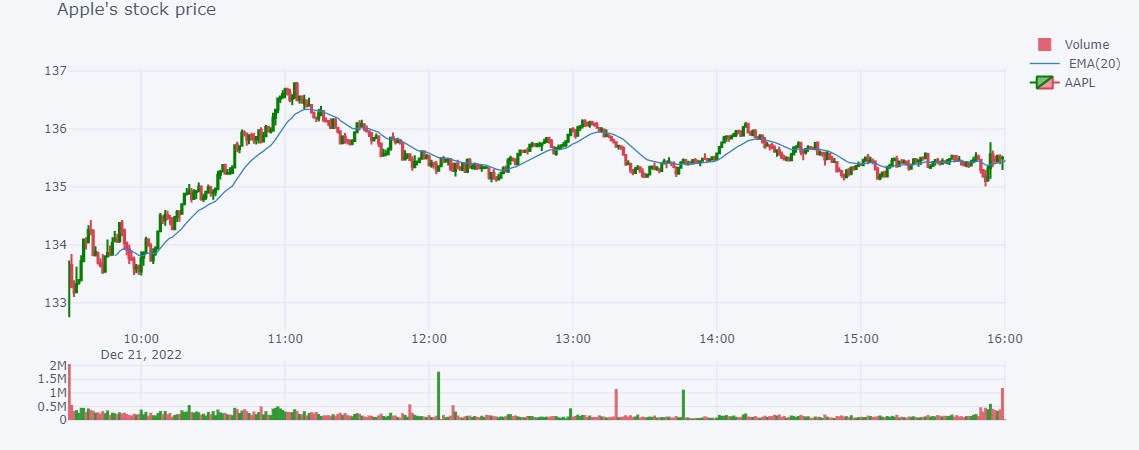

In [80]:
qf = cf.QuantFig(price_history, title="Apple's stock price", name='AAPL')
# qf.add_sma(periods=14, column='Close', color='blue')
qf.add_volume()
qf.add_ema()
qf.iplot(up_color="green", down_color="red")

## Reuters News

In [81]:
def scrape_reuters_news(ticker, date_range = "pastWeek"):
    # date_range can be: pastDay, pastWeek, pastMonth, and pastYear
    print(f"Search {ticker}'s {date_range} news")
    with requests.Session() as s:
        r = s.get(f'https://www.reuters.com/search/news?sortBy=date&dateRange={date_range}&blob={ticker}')
        soup = BeautifulSoup(r.content, 'lxml')
        num_results = soup.select_one('.search-result-count-num').text
        r = s.get(f'https://www.reuters.com/assets/searchArticleLoadMoreJson?blob={ticker}&bigOrSmall=big&articleWithBlog=true&sortBy=relevance&dateRange={date_range}&numResultsToShow={num_results}&pn=&callback=addMoreNewsResults')
        p = re.compile(r'id: "(.*?)"')
        p2 = re.compile(r'headline: "(.*?)"')
        links = [f'https://www.reuters.com/article/id{i}' for i in p.findall(r.text)]
        headlines = [BeautifulSoup(i, 'lxml').get_text() for i in p2.findall(r.text)]
    
    articles = []    
    cleaned_articles = []
    for link in links:
        paragraphs = ""
        scraped_data = urllib.request.urlopen(link)
        scraped_data = scraped_data.read()
        parsed_article = BeautifulSoup(scraped_data, 'lxml')
        article = parsed_article.find_all("p")
        
        for paragraph in article:
            paragraphs +=  paragraph.text + " "

        articles.append(paragraphs)
        paragraph_sents = sent_tokenize(paragraphs)
        sents = []
        
        for ps in paragraph_sents:
            ps = re.sub(r"\s+", " ", ps) # remove \n and \t
            ps = re.sub(r"[^\w\s]", "", ps) # remove punctuations
            ps = re.sub(r"[0-9]+", "", ps) # remove numbers
            ps = " ".join([word for word in tk.tokenize(ps.lower()) if word not in (stop)]) # remove stop words
            sents.append(ps)
            
        cleaned_articles.append(" ".join(sents))
        
    return headlines, articles, cleaned_articles

In [82]:
from datetime import datetime
from pytz import timezone
import pytz

date = datetime.now(tz=pytz.utc)
today = date.astimezone(timezone('US/Pacific')).strftime("%Y-%m-%d")
today

'2022-12-21'

In [83]:
def plot_stock_history(ticker, date = today):
    stock = yf.Ticker(ticker)
    price_history = stock.history(period = '1d', interval = '1m')
    qf = cf.QuantFig(price_history, title=f"{ticker}'s stock price", name=ticker)
#     qf.add_resistance(date = "21Dec22", color="orange")
    qf.add_volume()
    qf.add_ema()
    qf.iplot(up_color="green", down_color="red")

### Apple

In [84]:
ticker = "apple"
news = scrape_reuters_news(ticker)

news_data = pd.DataFrame({"title":news[0], "article":news[1], "cleaned_article":news[2]}).drop_duplicates()

article_polarity = []

for article in news_data["article"]:
    article_polarity.append(sia.polarity_scores(article)["compound"])
    
news_data["article_polarity"] = article_polarity

news_data.head()

Search apple's pastWeek news


,title,article,cleaned_article,article_polarity
0,Apple<\/b> finds a happy home in India,"BENGALURU, Dec 20 (Reuters Breakingviews) - In...",bengaluru dec reuters breakingviews india taki...,0.9945
1,"Australia takes aim at Apple<\/b>, Microsoft o...","SYDNEY, Dec 15 (Reuters) - An Australian regul...",sydney dec reuters australian regulator using ...,-0.9617
2,CORRECTED-App store avalanche forecast as Appl...,"LONDON, Dec 16 (Reuters) - Apple's rivals are ...",london dec reuters apples rivals positioning g...,0.9904
4,App store avalanche forecast as Apple<\/b> bow...,"LONDON, Dec 16 (Reuters) - Apple's rivals are ...",london dec reuters apples rivals positioning g...,0.9904
5,Factbox-Apple's<\/b> iPhone shipments seen sag...,Dec 20 (Reuters) - Apple Inc (AAPL.O) warned i...,dec reuters apple inc aaplo warned november wo...,0.8769


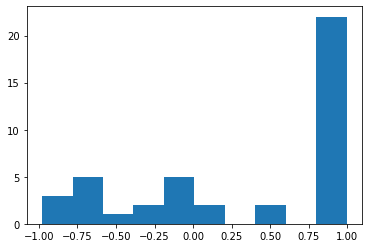

In [85]:
plt.figure()
plt.hist(news_data.article_polarity)
plt.show()

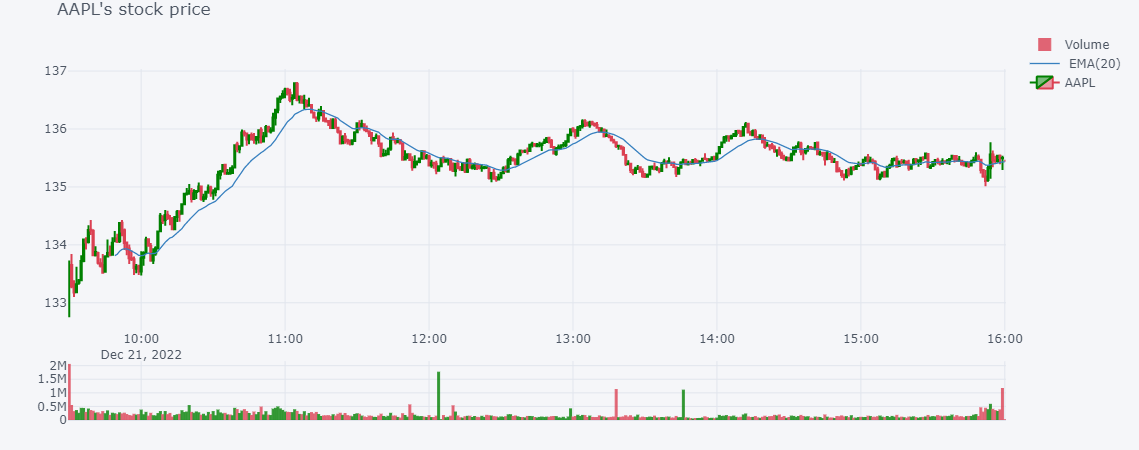

In [86]:
plot_stock_history("AAPL")

### GameStop

In [87]:
ticker = "gamestop"
news = scrape_reuters_news(ticker)

news_data = pd.DataFrame({"title":news[0], "article":news[1], "cleaned_article":news[2]}).drop_duplicates()

article_polarity = []

for article in news_data["article"]:
    article_polarity.append(sia.polarity_scores(article)["compound"])
    
news_data["article_polarity"] = article_polarity

news_data.head()

Search gamestop's pastWeek news


,title,article,cleaned_article,article_polarity
0,Retail investors turn to ETFs as recession fea...,Dec 16 (Reuters) - Retail investors are doubli...,dec reuters retail investors doubling exchange...,0.9916


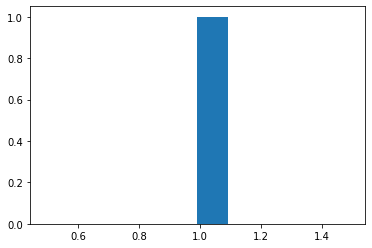

In [88]:
plt.figure()
plt.hist(news_data.article_polarity)
plt.show()

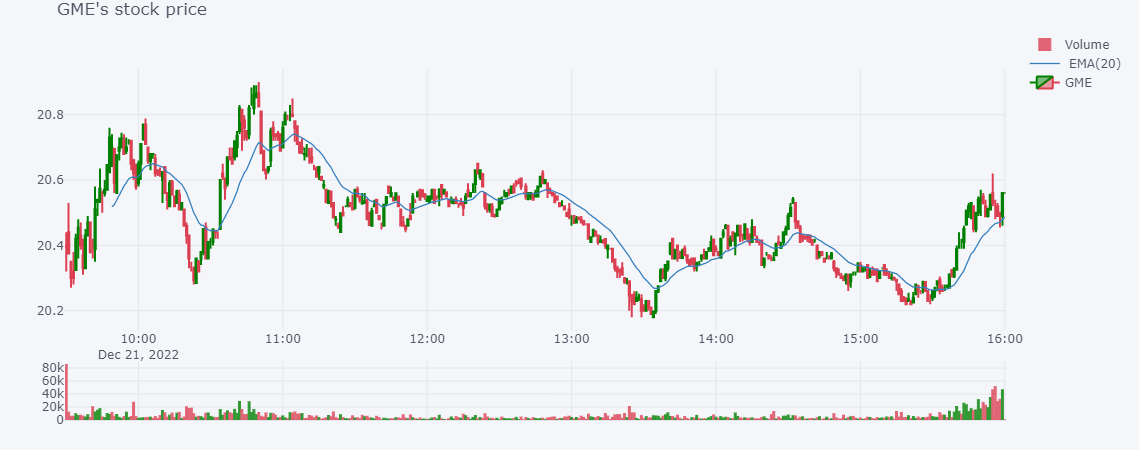

In [89]:
plot_stock_history("GME")

### Nokia

In [90]:
ticker = "nokia"
news = scrape_reuters_news(ticker)

news_data = pd.DataFrame({"title":news[0], "article":news[1], "cleaned_article":news[2]}).drop_duplicates()

article_polarity = []

for article in news_data["article"]:
    article_polarity.append(sia.polarity_scores(article)["compound"])
    
news_data["article_polarity"] = article_polarity

news_data.head()

Search nokia's pastWeek news


,title,article,cleaned_article,article_polarity
0,"Russian mobile calls, internet seen deteriorat...","STOCKHOLM/MOSCOW, Dec 21 (Reuters) - When tele...",stockholmmoscow dec reuters telecoms gear make...,0.9776
1,"FOCUS-Russian mobile calls, internet seen dete...","STOCKHOLM/MOSCOW, Dec 21 (Reuters) - When tele...",stockholmmoscow dec reuters telecoms gear make...,0.9776
2,"FOCUS-Russian mobile calls, internet seen dete...",Discover Thomson Reuters By Supantha Mukherjee...,discover thomson reuters supantha mukherjee al...,0.9487
3,"Ericsson sees margin at lower end of target, p...","STOCKHOLM, Dec 15 (Reuters) - Swedish telecom ...",stockholm dec reuters swedish telecom equipmen...,0.8615
4,UPDATE 4-Ericsson sees margin at lower end of ...,"LONDON/STOCKHOLM, Dec 15 (Reuters) - Swedish t...",londonstockholm dec reuters swedish telecom eq...,0.4221


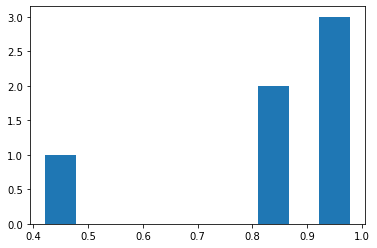

In [91]:
plt.figure()
plt.hist(news_data.article_polarity)
plt.show()

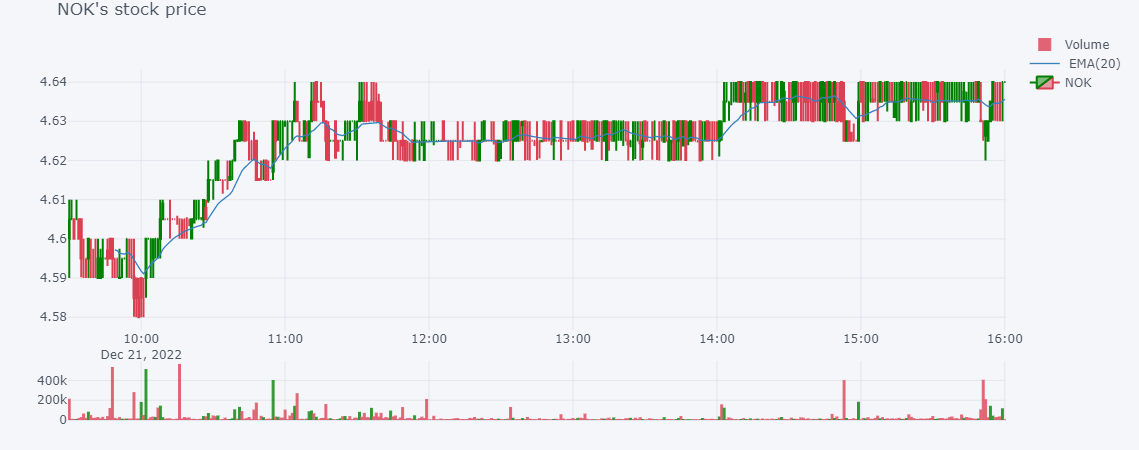

In [92]:
plot_stock_history("NOK")